In [1]:
import pandas as pd
from sqlalchemy import create_engine, text
from typing import Dict, List, Tuple, Optional
import re
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
def extract_salary_range(salary_text: str) -> tuple:
    """給与テキストから年収範囲を抽出する関数
    
    100万円以下の値は月給とみなして12倍する
    400～1000万円のような形式に対応
    """
    if not salary_text or salary_text.strip() == '-':
        return None, None
    
    # 「～」や「-」で区切られた範囲を処理
    range_match = re.search(r'(\d+)(?:万円)?[\-～](\d+)万円', salary_text)
    if range_match:
        min_sal = int(range_match.group(1))
        max_sal = int(range_match.group(2))
        # 100万円以下の値は月給とみなして12倍
        min_sal = min_sal * 12 if min_sal <= 100 else min_sal
        max_sal = max_sal * 12 if max_sal <= 100 else max_sal
        return min_sal, max_sal
    
    # 単一の値の処理
    numbers = re.findall(r'(\d+)万円', salary_text)
    if not numbers:
        return None, None
        
    numbers = [int(num) for num in numbers]
    numbers = [num * 12 if num <= 100 else num for num in numbers]
    
    if len(numbers) >= 2:
        return min(numbers), max(numbers)
    elif len(numbers) == 1:
        return numbers[0], numbers[0]
    
    return None, None

def calculate_salary_statistics(salary_list: List[tuple]) -> Dict:
   """給与データの統計情報を計算する関数"""
   valid_data = [(min_sal, max_sal) for min_sal, max_sal in salary_list if min_sal is not None and max_sal is not None]
   
   if not valid_data:
       return {
           'count': 0,
           'avg_min': None,
           'avg_max': None,
           'median_min': None,
           'median_max': None
       }
   
   min_salaries = [item[0] for item in valid_data]
   max_salaries = [item[1] for item in valid_data]
   
   return {
       'count': len(valid_data),
       'avg_min': round(statistics.mean(min_salaries), 1),
       'avg_max': round(statistics.mean(max_salaries), 1),
       'median_min': statistics.median(min_salaries),
       'median_max': statistics.median(max_salaries)
   }

def display_salary_analysis(results: Dict):
   """分析結果を整形して表示する関数"""
   for category, ranges in results.items():
       print(f"\n=== {category} ===")
       for range_name, stats in ranges.items():
           print(f"\n【{range_name}】")
           print(f"データ件数: {stats['count']}件")
           if stats['count'] > 0:
               print(f"平均年収範囲: {stats['avg_min']}万円 ～ {stats['avg_max']}万円")
               print(f"中央値年収範囲: {stats['median_min']}万円 ～ {stats['median_max']}万円")

def analyze_salaries_by_category():
    """カテゴリごとの年収分析を行う関数"""
    engine = create_engine('sqlite:///type_jp_jobs.db')
    
    # salary_detail を job_content に変更
    query = """
    SELECT 
        jc.name as category,
        j.rank,
        j.salary_summary,
        j.job_content
    FROM jobs j
    JOIN job_categories jc ON j.category_id = jc.id
    ORDER BY jc.name, j.rank
    """
    
    with engine.connect() as connection:
        result = connection.execute(text(query))
        rows = result.fetchall()
        columns = result.keys()
        df = pd.DataFrame(rows, columns=columns)
    
    results = {}
    
    for category in df['category'].unique():
        category_df = df[df['category'] == category]
        
        ranges = {
            '1-10位': (1, 10),
            '11-20位': (11, 20),
        }
        
        category_results = {}
        for range_name, (start, end) in ranges.items():
            range_df = category_df[
                (category_df['rank'] >= start) & 
                (category_df['rank'] <= end)
            ]
            
            salary_ranges = [
                extract_salary_range(f"{row['salary_summary']} {row['job_content']}")
                for _, row in range_df.iterrows()
            ]
            
            stats = calculate_salary_statistics(salary_ranges)
            category_results[range_name] = stats
            
        results[category] = category_results
    
    return results

In [3]:
# 分析の実行
results = analyze_salaries_by_category()
display_salary_analysis(results)


=== PM ===

【1-10位】
データ件数: 10件
平均年収範囲: 525万円 ～ 1265万円
中央値年収範囲: 500.0万円 ～ 1350.0万円

【11-20位】
データ件数: 8件
平均年収範囲: 414万円 ～ 1018.8万円
中央値年収範囲: 425.0万円 ～ 1050.0万円

=== その他 ===

【1-10位】
データ件数: 8件
平均年収範囲: 325万円 ～ 725万円
中央値年収範囲: 325.0万円 ～ 650.0万円

【11-20位】
データ件数: 10件
平均年収範囲: 335万円 ～ 675万円
中央値年収範囲: 300.0万円 ～ 600.0万円

=== インフラ ===

【1-10位】
データ件数: 10件
平均年収範囲: 360万円 ～ 810万円
中央値年収範囲: 375.0万円 ～ 825.0万円

【11-20位】
データ件数: 10件
平均年収範囲: 410万円 ～ 880万円
中央値年収範囲: 400.0万円 ～ 850.0万円

=== エンジニア ===

【1-10位】
データ件数: 10件
平均年収範囲: 395万円 ～ 715万円
中央値年収範囲: 300.0万円 ～ 650.0万円

【11-20位】
データ件数: 10件
平均年収範囲: 365万円 ～ 775万円
中央値年収範囲: 350.0万円 ～ 750.0万円

=== オフィス ===

【1-10位】
データ件数: 10件
平均年収範囲: 304万円 ～ 731万円
中央値年収範囲: 300.0万円 ～ 655.0万円

【11-20位】
データ件数: 10件
平均年収範囲: 272万円 ～ 597.6万円
中央値年収範囲: 300.0万円 ～ 525.0万円

=== サービス ===

【1-10位】
データ件数: 9件
平均年収範囲: 338.9万円 ～ 472.2万円
中央値年収範囲: 350万円 ～ 450万円

【11-20位】
データ件数: 10件
平均年収範囲: 330万円 ～ 530万円
中央値年収範囲: 300.0万円 ～ 525.0万円

=== 営業 ===

【1-10位】
データ件数: 8件
平均年収範囲: 437.5万円 ～ 856.2万円
中央値年収範囲: 450.0万円 ～ 875

In [4]:
def prepare_visualization_data(results: Dict) -> pd.DataFrame:
    """結果をDataFrame形式に変換する関数"""
    data = []
    
    for category, ranges in results.items():
        # 全てのランク範囲のデータを集計
        total_count = sum(r['count'] for r in ranges.values())
        if total_count > 0:
            # 加重平均を計算
            weighted_min = sum(r['avg_min'] * r['count'] for r in ranges.values() if r['count'] > 0) / total_count
            weighted_max = sum(r['avg_max'] * r['count'] for r in ranges.values() if r['count'] > 0) / total_count
            
            data.append({
                'カテゴリ': category,
                '最小年収': round(weighted_min, 1),
                '最大年収': round(weighted_max, 1),
                'データ件数': total_count
            })
    
    return pd.DataFrame(data)

def plot_salary_summary(df: pd.DataFrame):
    """職種カテゴリ別の給与データを可視化する関数"""
    if df.empty:
        print("有効な給与データがありません。")
        return
        
    df_sorted = df.sort_values('最大年収', ascending=False)
    
    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    
    x = np.arange(len(df_sorted['カテゴリ']))
    width = 0.7
    
    bars1 = ax.bar(x, 
                   df_sorted['最小年収'],
                   width,
                   label='最小年収',
                   color='#2E86C1')
    
    bars2 = ax.bar(x,
                   df_sorted['最大年収'] - df_sorted['最小年収'],
                   width,
                   bottom=df_sorted['最小年収'],
                   label='年収範囲',
                   color='#F39C12',
                   alpha=0.8)
    
    medians = (df_sorted['最小年収'] + df_sorted['最大年収']) / 2
    ax.scatter(x, medians, color='red', s=100, zorder=3, label='中央値', marker='D')
    
    ax.set_xlabel("職種カテゴリ", fontname="MS Gothic", fontsize=10)
    ax.set_ylabel("年収 (万円)", fontname="MS Gothic", fontsize=10)
    plt.title("職種カテゴリ別の年収範囲（最大年収順）", fontname="MS Gothic", fontsize=12, pad=15)
    
    ax.set_xticks(x)
    ax.set_xticklabels(df_sorted['カテゴリ'], rotation=45, ha='right', fontname="MS Gothic", fontsize=9)
    
    for i in range(len(x)):
        min_val = int(df_sorted.iloc[i]['最小年収'])
        max_val = int(df_sorted.iloc[i]['最大年収'])
        med_val = int(medians.iloc[i])
        
        ax.text(x[i], min_val/2,
                f'{min_val}万',
                ha='center', va='center',
                fontname="MS Gothic",
                fontsize=9,
                color='white',
                weight='bold')
        
        ax.text(x[i], min_val + (max_val - min_val)/2,
                f'{max_val}万',
                ha='center', va='center',
                fontname="MS Gothic",
                fontsize=9,
                color='black',
                weight='bold')
        
        ax.text(x[i], med_val,
                f'↙{med_val}万',
                ha='right', va='bottom',
                fontname="MS Gothic",
                fontsize=9,
                color='red',
                weight='bold')
    
    ax.legend(loc='upper right', prop={'family': 'MS Gothic', 'size': 9})
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    ax.set_ylim(0, df_sorted['最大年収'].max() * 1.1)
    
    plt.tight_layout()
    plt.show()

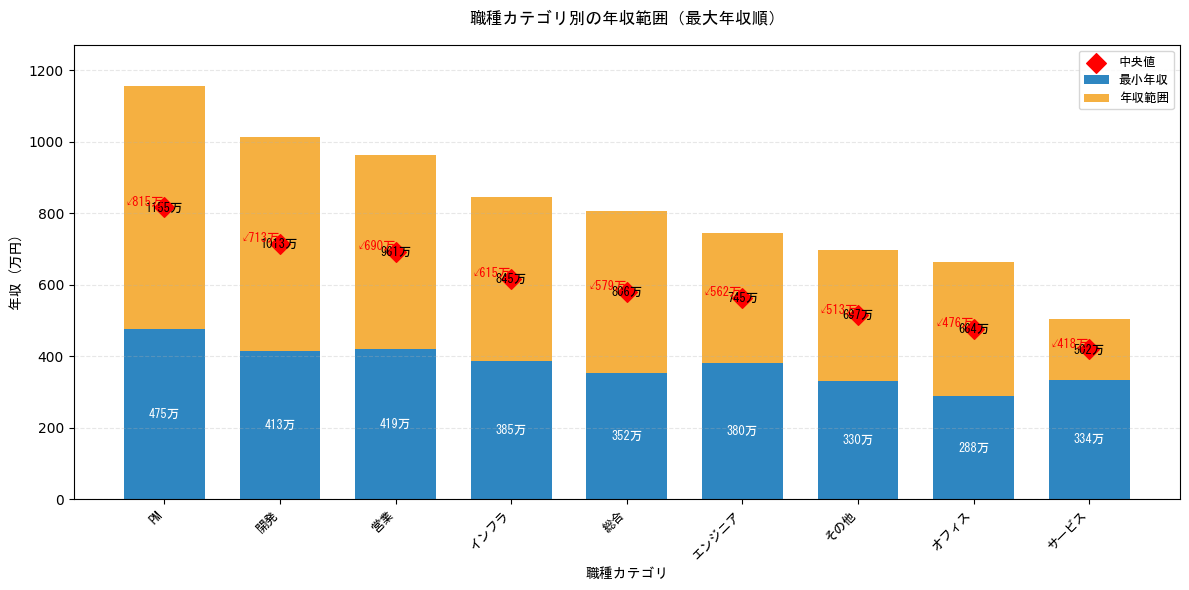

In [5]:
# 実行
viz_df = prepare_visualization_data(results)
plot_salary_summary(viz_df)

## 転職typeの職種カテゴリごとの人気ランキングTop20 の年収の分布と考察
- まず、総合ランキングTop20は総じて年収が高いと言える。つまりは年収が比較的高い求人情報は人気になりやすいと言える。
- 最上位（総合職）と最下位（サービス）の年収上限差は約750万円
- 最低年収の差は約180万円程度で、上限ほどの大きな差は見られない
- 技術職は総じてサービス職よりも年収が高い傾向にある
- どの職種でも年収範囲が広く、成果報酬型の特徴が現れている
- 中途採用に特化したサイトであるためか、ほぼすべての職種で年収範囲の幅が大きく、経験やスキルによる昇給の余地が大きいことが示される

## 求人情報のテキストから、職種ごとの特徴を調査する

In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, models
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import logging
from janome.tokenizer import Tokenizer
from sqlalchemy import create_engine
from math import ceil

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

データの読み込み中...
TF-IDF分析の実行中...
結果の可視化...


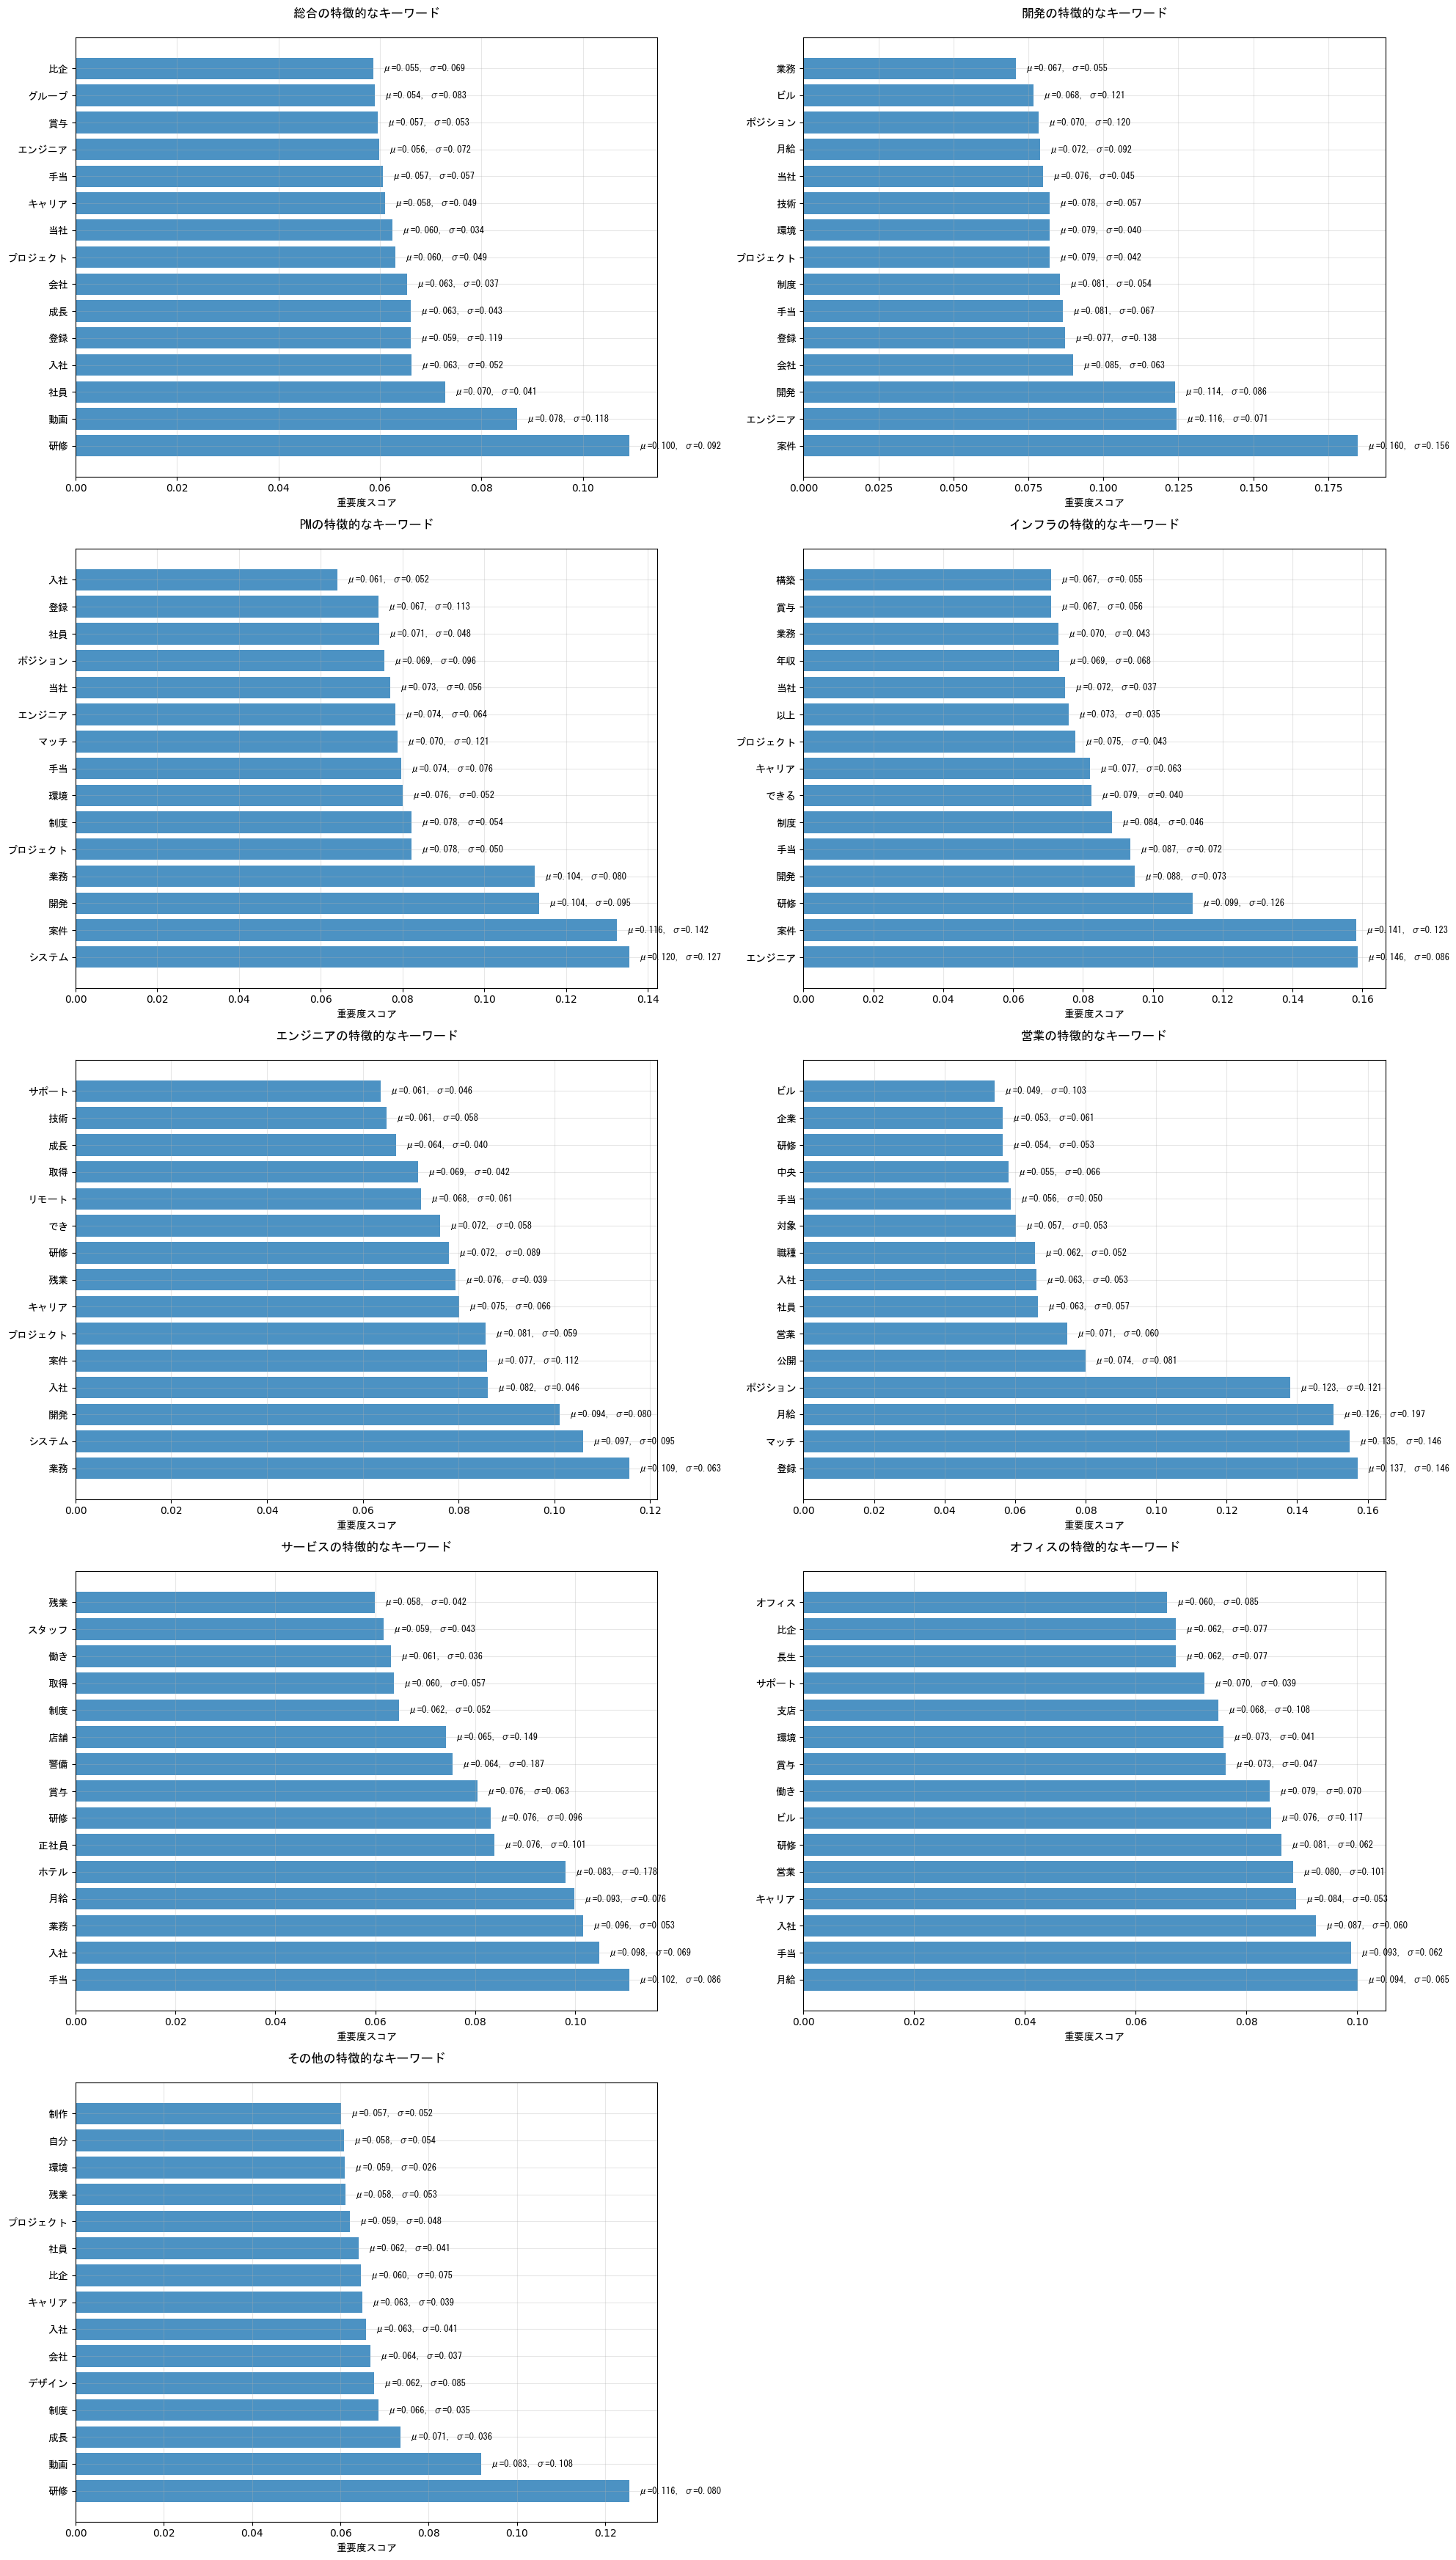


=== 最も似ている職種カテゴリTop5 ===
開発 - PM: 0.600
総合 - その他: 0.481
開発 - インフラ: 0.379
PM - インフラ: 0.379
PM - その他: 0.379

=== 最も似ていない職種カテゴリTop5 ===
サービス - その他: 0.176
営業 - サービス: 0.143
PM - オフィス: 0.111
インフラ - 営業: 0.111
エンジニア - 営業: 0.081


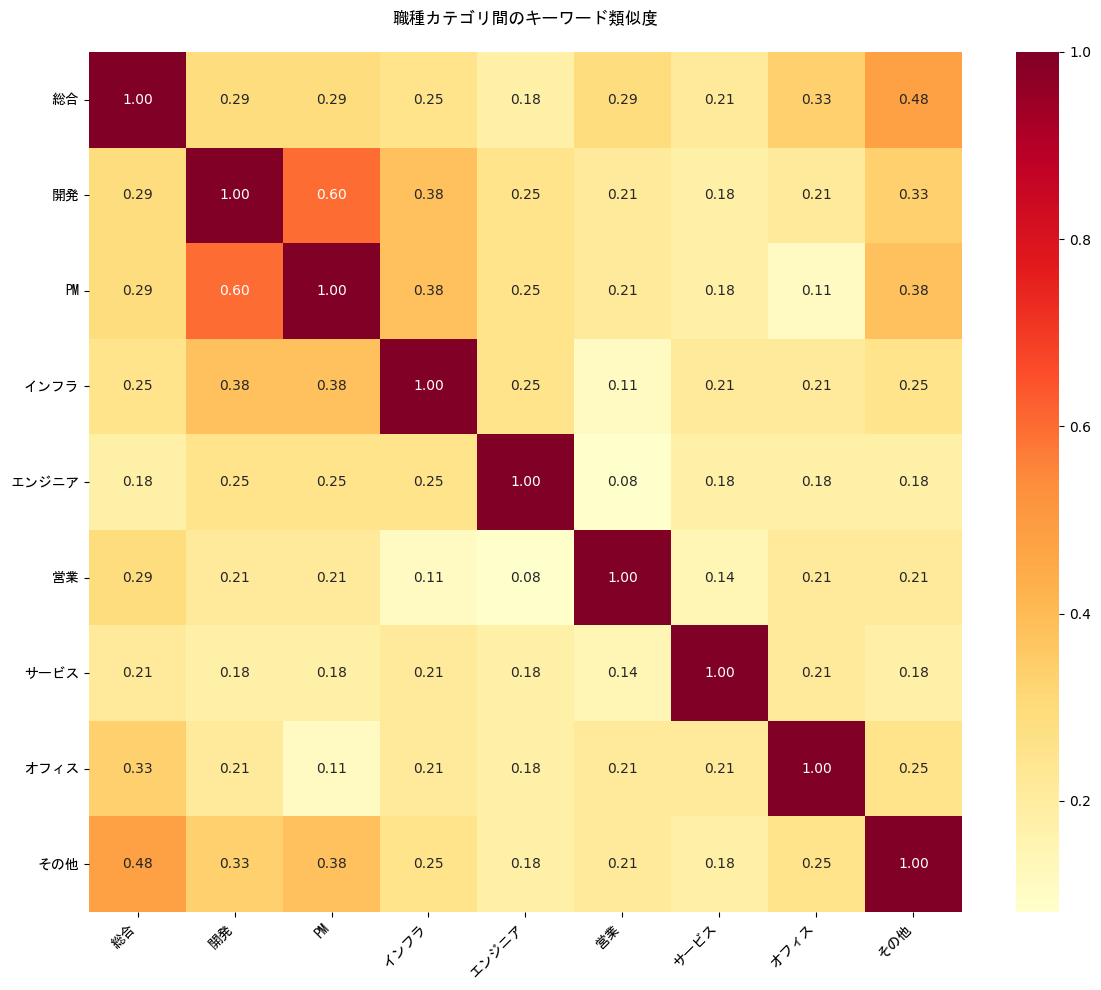

分析結果をdetailed_tfidf_analysis.csvに保存しました


In [7]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sqlalchemy import create_engine
from janome.tokenizer import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

def load_job_data():
    """データベースから求人データを読み込む"""
    engine = create_engine('sqlite:///type_jp_jobs.db')
    query = """
    SELECT 
        j.job_content,
        j.company_profile,
        jc.name as job_category
    FROM jobs j
    JOIN job_categories jc ON j.category_id = jc.id
    """
    with engine.connect() as connection:
        df = pd.read_sql(query, connection)
    return df

def preprocess_text(text):
    """テキストの前処理"""
    if pd.isna(text):
        return ''
    # URLの削除
    text = re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', str(text))
    # 特殊文字、数字、記号の削除
    text = re.sub(r'[【】\[\],()（）.・:：%％\-\/\d]+', ' ', text)
    # 英数字の削除
    text = re.sub(r'[a-zA-Z0-9]+', ' ', text)
    # 改行、タブの削除
    text = re.sub(r'[\n\r\t]', ' ', text)
    # 複数スペースを単一スペースに
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def tokenize_with_janome(text):
    """Janomeによる形態素解析"""
    t = Tokenizer()
    stop_words = {'円', '万', 'する', 'なる', 'いる', 'ある', 'こと', 'もの', 'よう', 'れる', 'られる', 
            'など', 'まで', 'から', 'それ', 'これ', 'どれ', 'ため', 'もう', 'また', 'や', 'の', 
            'を', 'に', 'へ', 'で', 'と', 'が', 'は', 'い', 'あり', 'なし', 'もし', 'どう',
            '市', '県', '区', '町', '村', '郡', '駅', '線', '徒歩', '分',
            # 主要都市
            '名古屋', '横浜', '神戸', '札幌', '仙台', '川崎', 'さいたま',
            # 47都道府県
            '北海道', '青森', '岩手', '宮城', '秋田', '山形', '福島',
            '茨城', '栃木', '群馬', '埼玉', '千葉', '東京', '神奈川',
            '新潟', '富山', '石川', '福井', '山梨', '長野', '岐阜',
            '静岡', '愛知', '三重', '滋賀', '京都', '大阪', '兵庫',
            '奈良', '和歌山', '鳥取', '島根', '岡山', '広島', '山口',
            '徳島', '香川', '愛媛', '高知', '福岡', '佐賀', '長崎',
            '熊本', '大分', '宮崎', '鹿児島', '沖縄'
    }
    
    tokens = []
    for token in t.tokenize(text):
        pos = token.part_of_speech.split(',')[0]
        if len(token.surface) > 1 and pos in ['名詞', '動詞', '形容詞']:
            word = token.surface
            if word not in stop_words and not any(char.isdigit() for char in word):
                tokens.append(word)
    return tokens

def analyze_tfidf_by_category(df):
    """カテゴリ別のTF-IDF分析"""
    df['combined_text'] = df['job_content'].fillna('') + ' ' + df['company_profile'].fillna('')
    df['cleaned_text'] = df['combined_text'].apply(preprocess_text)
    
    tfidf = TfidfVectorizer(
        tokenizer=tokenize_with_janome,
        min_df=3,
        max_df=0.95
    )
    
    category_analysis = {}
    
    for category in df['job_category'].unique():
        category_texts = df[df['job_category'] == category]['cleaned_text']
        if len(category_texts) > 0:
            tfidf_matrix = tfidf.fit_transform(category_texts)
            feature_names = tfidf.get_feature_names_out()
            
            dense_matrix = tfidf_matrix.toarray()
            avg_tfidf = np.mean(dense_matrix, axis=0)
            std_tfidf = np.std(dense_matrix, axis=0)
            
            importance_score = avg_tfidf * (1 + std_tfidf)
            
            top_indices = importance_score.argsort()[-30:][::-1]
            category_analysis[category] = {
                'words': [feature_names[i] for i in top_indices],
                'scores': [importance_score[i] for i in top_indices],
                'avg_scores': [avg_tfidf[i] for i in top_indices],
                'std_scores': [std_tfidf[i] for i in top_indices]
            }
    
    return category_analysis

def visualize_category_keywords(analysis_results):
    """分析結果の可視化"""
    n_categories = len(analysis_results)
    n_cols = 2
    n_rows = (n_categories + n_cols - 1) // n_cols
    
    plt.figure(figsize=(20, 7*n_rows))
    
    for idx, (category, data) in enumerate(analysis_results.items(), 1):
        words = data['words'][:15]
        scores = data['scores'][:15]
        avg_scores = data['avg_scores'][:15]
        std_scores = data['std_scores'][:15]
        
        plt.subplot(n_rows, n_cols, idx)
        bars = plt.barh(range(len(words)), scores, alpha=0.8)
        plt.yticks(range(len(words)), words, fontname="MS Gothic")
        plt.xlabel('重要度スコア', fontname="MS Gothic")
        plt.title(f'{category}の特徴的なキーワード', fontname="MS Gothic", pad=20)
        
        for i, (word, score, avg, std) in enumerate(zip(words, scores, avg_scores, std_scores)):
            plt.text(score, i, f'  μ={avg:.3f}, σ={std:.3f}', 
                    va='center', fontname="MS Gothic", fontsize=9)
        
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def create_category_heatmap(analysis_results):
    """カテゴリ間のキーワード類似性をヒートマップで可視化"""
    categories = list(analysis_results.keys())
    n_categories = len(categories)
    similarity_matrix = np.zeros((n_categories, n_categories))
    
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            words1 = set(analysis_results[cat1]['words'][:20])
            words2 = set(analysis_results[cat2]['words'][:20])
            similarity = len(words1 & words2) / len(words1 | words2)
            similarity_matrix[i, j] = similarity
    
    similarity_pairs = []
    for i in range(n_categories):
        for j in range(i + 1, n_categories):
            similarity_pairs.append({
                'category1': categories[i],
                'category2': categories[j],
                'similarity': similarity_matrix[i, j]
            })
    
    similarity_pairs_sorted = sorted(similarity_pairs, key=lambda x: x['similarity'], reverse=True)
    
    print("\n=== 最も似ている職種カテゴリTop5 ===")
    for pair in similarity_pairs_sorted[:5]:
        print(f"{pair['category1']} - {pair['category2']}: {pair['similarity']:.3f}")
    
    print("\n=== 最も似ていない職種カテゴリTop5 ===")
    for pair in similarity_pairs_sorted[-5:]:
        print(f"{pair['category1']} - {pair['category2']}: {pair['similarity']:.3f}")
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(similarity_matrix, 
                xticklabels=categories,
                yticklabels=categories,
                annot=True,
                fmt='.2f',
                cmap='YlOrRd')
    
    plt.xticks(rotation=45, ha='right', fontname="MS Gothic")
    plt.yticks(rotation=0, fontname="MS Gothic")
    plt.title('職種カテゴリ間のキーワード類似度', fontname="MS Gothic", pad=20)
    plt.tight_layout()
    plt.show()

def main():
    print("データの読み込み中...")
    df = load_job_data()
    
    print("TF-IDF分析の実行中...")
    analysis_results = analyze_tfidf_by_category(df)
    
    print("結果の可視化...")
    visualize_category_keywords(analysis_results)
    create_category_heatmap(analysis_results)
    
    results_list = []
    for category, data in analysis_results.items():
        for word, score, avg, std in zip(data['words'], data['scores'], 
                                       data['avg_scores'], data['std_scores']):
            results_list.append({
                'category': category,
                'keyword': word,
                'importance_score': score,
                'avg_tfidf': avg,
                'std_tfidf': std
            })
    
    results_df = pd.DataFrame(results_list)
    results_df.to_csv('detailed_tfidf_analysis.csv', 
                      index=False, encoding='utf-8-sig')
    print("分析結果をdetailed_tfidf_analysis.csvに保存しました")

if __name__ == "__main__":
    main()

## TF-IDFによる業種分析について
この画像は異なる職種カテゴリにおけるキーワードのTF-IDF分析結果を示す複数の棒グラフである. 各グラフには重要度スコア (μ：平均値, σ：標準偏差) が示されており, 職種ごとの特徴的な要素を定量的に把握することができる.  
職種カテゴリの分析から, エンジニア系ではシステムやAIに関連するキーワードが高いスコアを示し, 専門的な技術用語が多く出現している. また, プロジェクトやマネジメント関連のキーワードも上位に入っており, 技術と管理の両面が求められることが分かる. 開発系/技術系はエンジニア系と類似した傾向を示すが, より具体的な開発関連のキーワードが上位に位置している. これは類似度分析でも確認でき, 開発とPMの類似度が0.600と最も高い値を示している. 一方, サービス系では顧客やサポート関連のキーワードが特徴的であり, マネジメントや運営に関する用語が多く出現している.  
職種間の比較から, 技術系職種は専門用語や技術スキルが重視される一方, 非技術系職種では対人スキルやマネジメント能力が重視されることが明らかになった. この傾向は類似度分析からも裏付けられ, エンジニアと営業 (0.081), インフラと営業 (0.111) など, 技術系と非技術系の職種間で最も低い類似度を示している. しかし, どの職種においてもプロジェクトやマネジメント関連のキーワード, およびチームワークや協働を表す用語が共通して出現している. これは, 職種の専門性に関わらず, これらのスキルが基礎的な要件となっていることを表している. 総じて, 各職種カテゴリで求められるスキルや経験は明確に分かれているものの, マネジメントやチームワークといった共通要素の重要性が確認された.  